In [1]:
%load_ext rpy2.ipython

In [3]:
%%R
library(DESeq2,quietly = TRUE)
library(tidyverse, quietly = TRUE)
library(ggplot2, quietly = TRUE)
library(gridExtra, quietly = TRUE)
# library(ggrepel, quietly = TRUE)
library(EnhancedVolcano, quietly = TRUE)
# library(ggpubr, quietly = TRUE)

### Model 
> 1. sensory water as sample_1 and sensory 50uM OXL as sample_2
> 2. enteric water as sample_1 and enteric 50uM OXL as sample_2
> 3. sensory water as sample_1 and enteric water as sample_2
> 4. sensory 50uM OXL as sample_1 and enteric 50uM OXL as sample_2


In [18]:
%%R
sample.type <- c(rep("enteric",2), "sensory", rep("enteric",2), rep("sensory",2))
sample.cond <- c('50uM_OXL',rep('water',2), rep(c('50uM_OXL', 'water'),2))
replicate <- c(rep('1',3),'2', '2', '','2')
all_cond <- paste(sample.type, sample.cond, replicate, sep="_")
conds <- paste(sample.type, sample.cond, sep="_")

model_1 = c("sensory_water", "sensory_50uM_OXL")
model_2 = c("enteric_water", "enteric_50uM_OXL")
model_3 = c("sensory_water", "enteric_water")
model_4 = c("sensory_50uM_OXL", "enteric_50uM_OXL")

files <- list.files(pattern=".fc$")[-c(1,2)]

datalist <- lapply(files, function(x){read.table(file=x,header=TRUE,colClasses=c(NA, "NULL", "NULL", "NULL", "NULL", "NULL", NA),check.names=F)})
m <- Reduce(function(...) merge(..., by=1, all = TRUE), datalist)
rownames(m) <- m[,1]
m <- m[,-1]
m[is.na(m)]<-0
m <- round(m)
colnames(m) <- all_cond

In [79]:
%%R
for (i in c(1:4)){
    model = get(paste('model',i,sep='_'))

    samples <- rep('skip', length(cond))
    samples[which(conds == model[1])] <- 'sample_1'
    samples[which(conds == model[2])] <- 'sample_2'
    cond <- paste(sample.type[which(samples != 'skip')], sample.cond[which(samples != 'skip')], sep="_")

    mm <- m[,which(samples != 'skip')]

    colData <- data.frame(cond, row.names=colnames(mm))
    dds <- DESeqDataSetFromMatrix(countData = mm, colData = colData, design = ~ cond)
    dds$cond <- relevel(dds$cond, ref=model[1])
    dds <- DESeq(dds)
    cds <- estimateDispersions(dds)
    vsd <- varianceStabilizingTransformation(cds)
    ## PCA Plot 
    z <- plotPCA(vsd,intgroup=c("cond"), returnData=TRUE)
    percentVar <- round(100 * attr(z, "percentVar"))
    p <- ggplot(z, aes(PC1, PC2)) +
      geom_point(aes(size = 4)) +
      ggtitle(paste('Model', i,':', model[1], 'vs', model[2])) + 
      xlab(paste0("PC1: ",percentVar[1],"% variance")) +
      ylab(paste0("PC2: ",percentVar[2],"% variance")) +
      geom_label_repel(label = cond, force = 10) +
      guides(size = FALSE)
    ggsave(paste('model_',i,'.png',sep=''), plot = p, device = 'png', dpi = 300)

    # normalized counts 
    ncu <- counts(dds, normalized=TRUE)
    # Raw tabels 
    write.table(ncu, file=paste('model',i,"gene_count_table_DE2norm.txt", sep='_'), sep="\t", quote=FALSE, col.names=colnames(mm)) 
    write.table(mm, file=paste('model',i,"gene_count_table_raw.txt", sep='_'), sep="\t", quote=FALSE, col.names=colnames(mm))
    # model:
    res <- results(dds)
    write.table(res, paste(paste('model',i, model[1], 'vs', model[2], sep='_'), ".txt", sep=''), sep="\t", quote=FALSE, col.names=NA)
    # Positive results 
    res <- data.frame(res, row.names = rownames(res))
    positive_res <- res %>% 
                    rownames_to_column('gene') %>%
                    filter(log2FoldChange > 0 & pvalue < 1e-3)
    positive_ncu <- ncu[positive_res$gene,]

    write.table(positive_res, file=paste('model',i, model[1], 'vs', model[2], "positive.txt", sep='_'), sep="\t", quote=FALSE, col.names=NA )
    write.table(positive_ncu, file=paste('model',i,"positive_gene_count_table_DE2norm.txt", sep='_'), sep="\t", quote=FALSE, col.names=colnames(mm)) 
    # Print model results:
    resultsNames(dds)
}

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: found already estimated dispersions, replacing these

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: found

In [80]:
import pandas
from IPython.display import Image

In [81]:
fs = %R list.files(pattern="positive.txt$")

# 1

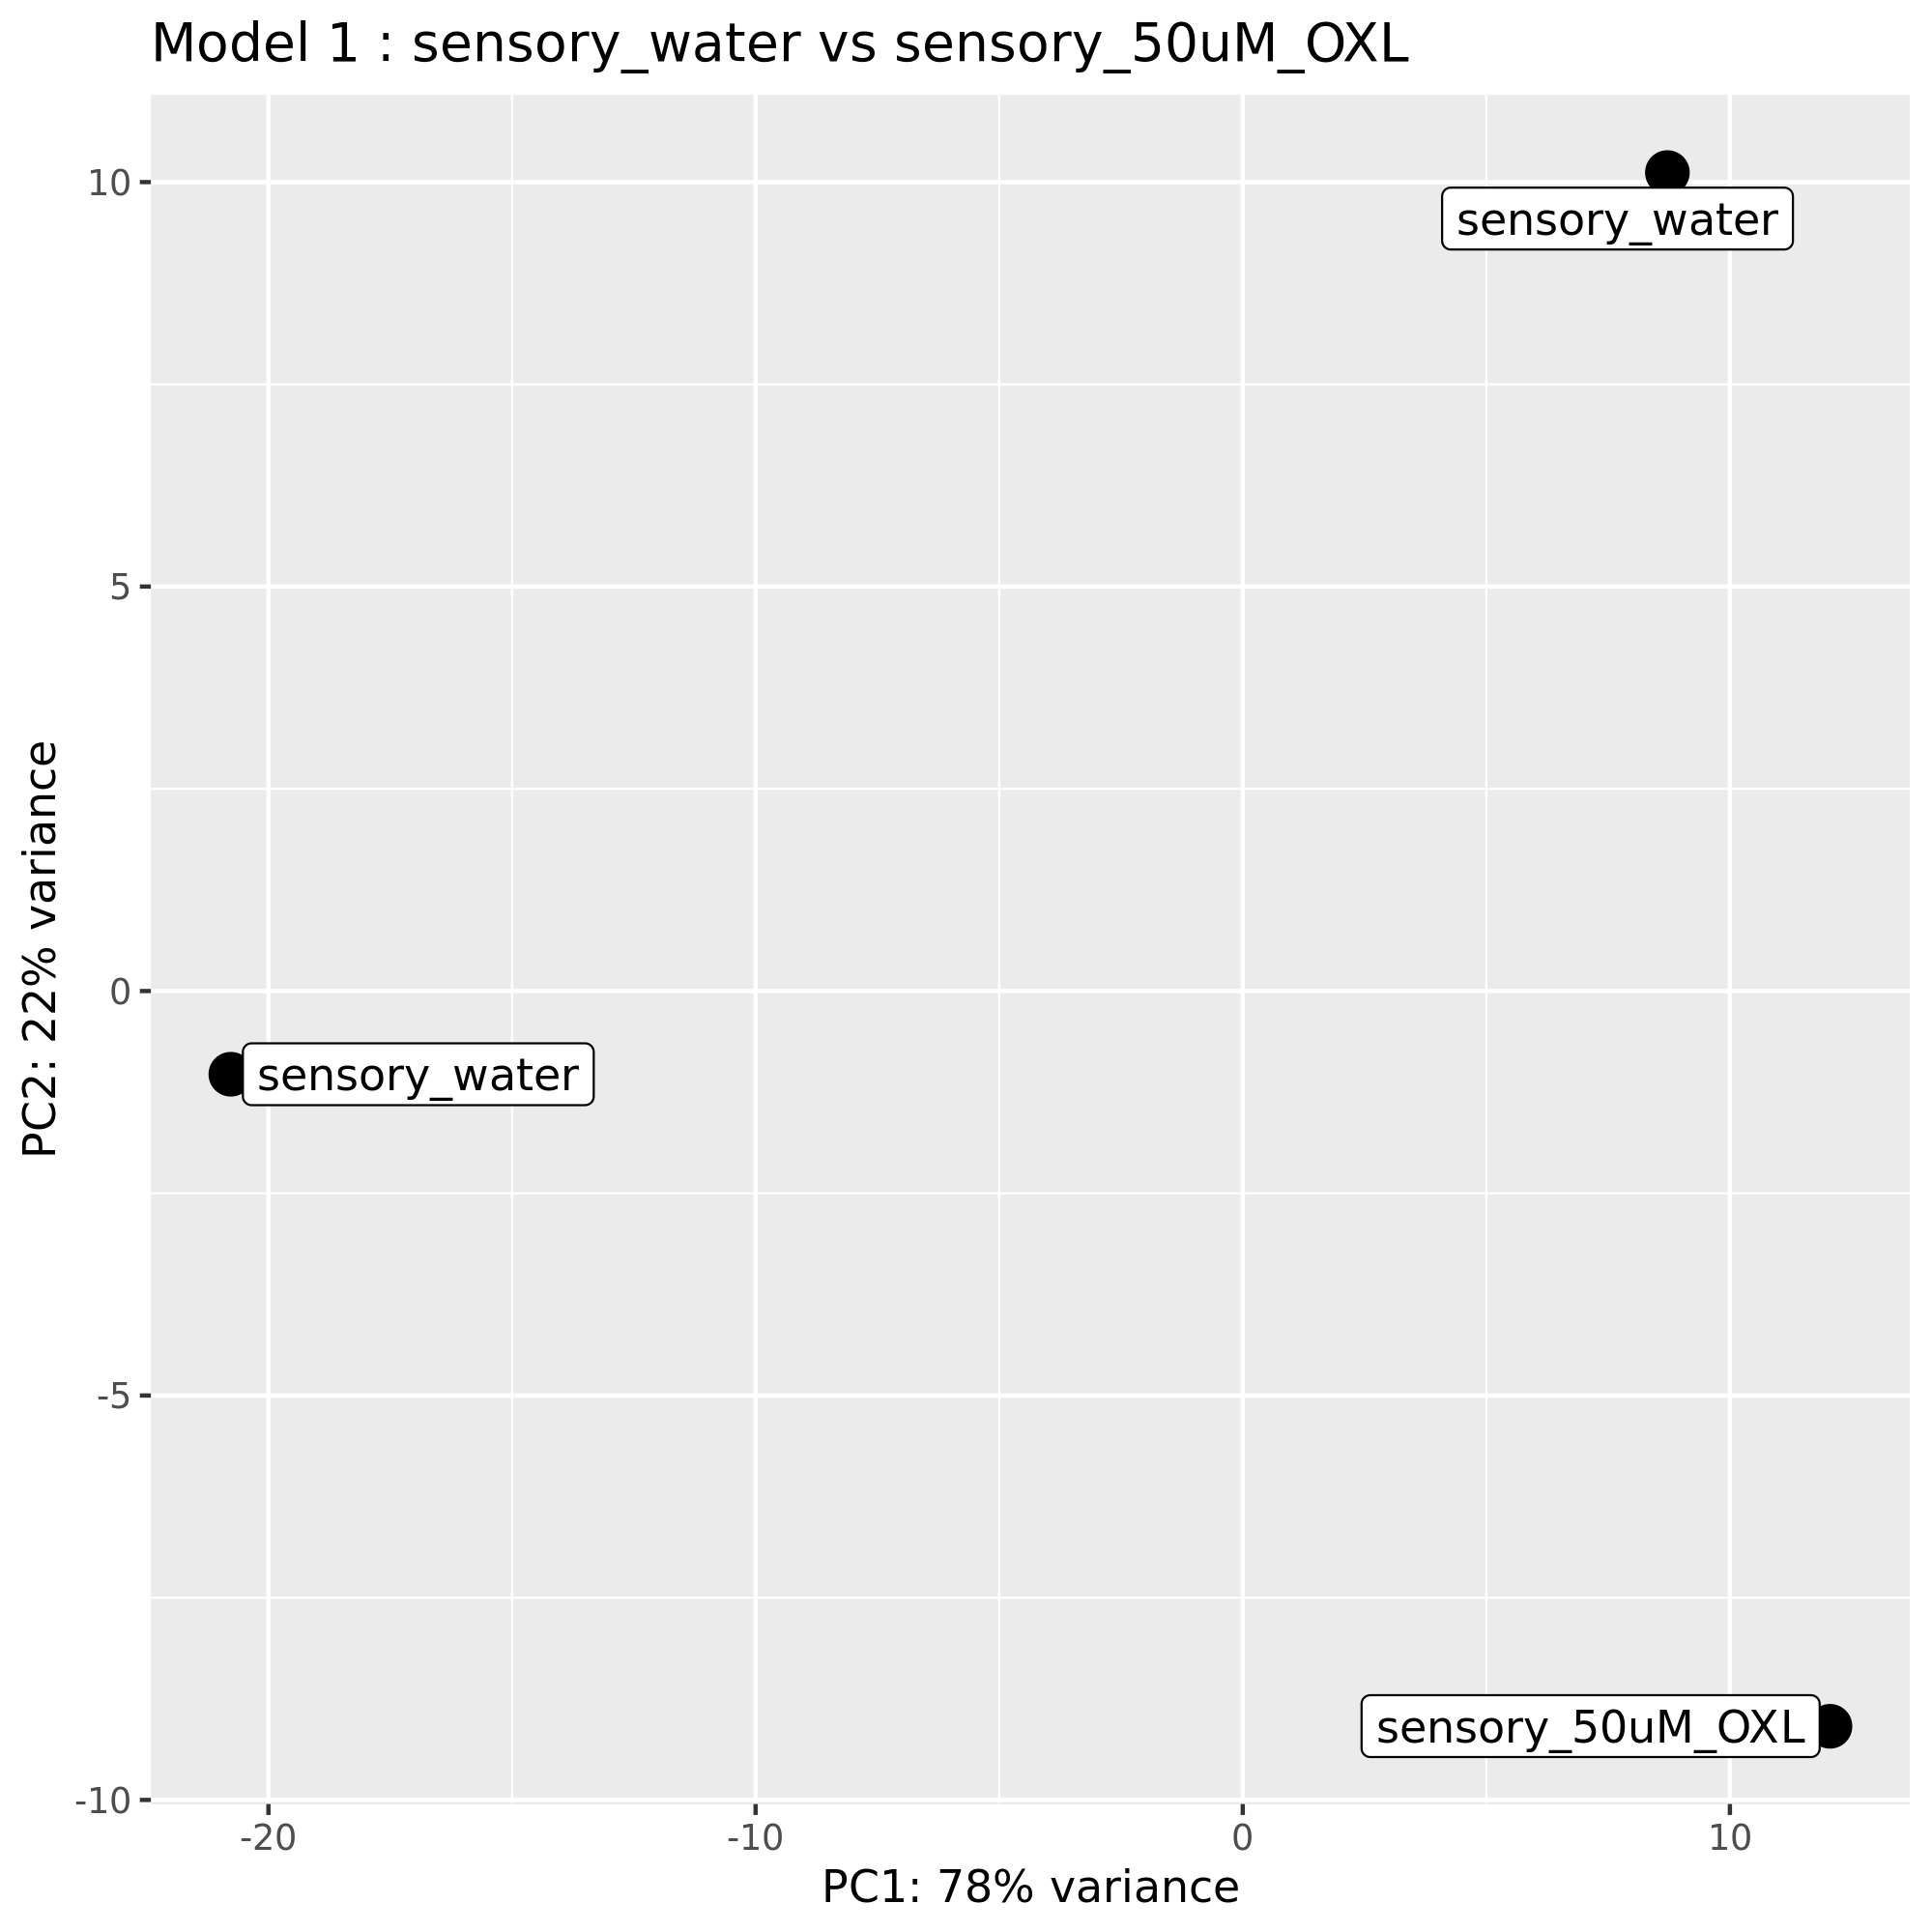

In [82]:
Image("model_1.png", width=500)

In [83]:
print (fs[0])
print(pandas.read_csv(fs[0], sep='\t')[['gene', 'pvalue','log2FoldChange']] )

model_1_sensory_water_vs_sensory_50uM_OXL_positive.txt
          gene        pvalue  log2FoldChange
0       CDKN1A  1.691758e-07        4.122696
1         FDXR  7.570377e-06        3.647630
2        KRT17  1.745369e-04        6.280062
3        RN7SK  4.615358e-07        4.644007
4      RNA28S5  9.979777e-04        5.403054
5       RNU4-1  1.354829e-08        6.225483
6       RNU4-2  7.684683e-08        4.354506
7      RNU5B-1  1.761401e-04        6.565711
8     RNU6ATAC  2.657630e-05        9.188238
9         RNY5  1.193218e-16        6.112783
10    SCARNA17  1.541592e-06        6.523482
11     SCARNA2  3.463261e-05        4.197021
12    SNCA-AS1  8.583122e-04        8.436725
13     SNORA2B  9.205741e-05        8.940307
14     SNORA48  3.403850e-04        8.656510
15    SNORA80E  3.503514e-05        6.161071
16  SNORD116-2  5.173550e-04        8.559211
17     SNORD3A  5.561686e-04        8.542337
18    SNORD83B  9.238868e-04        8.418346


# 2

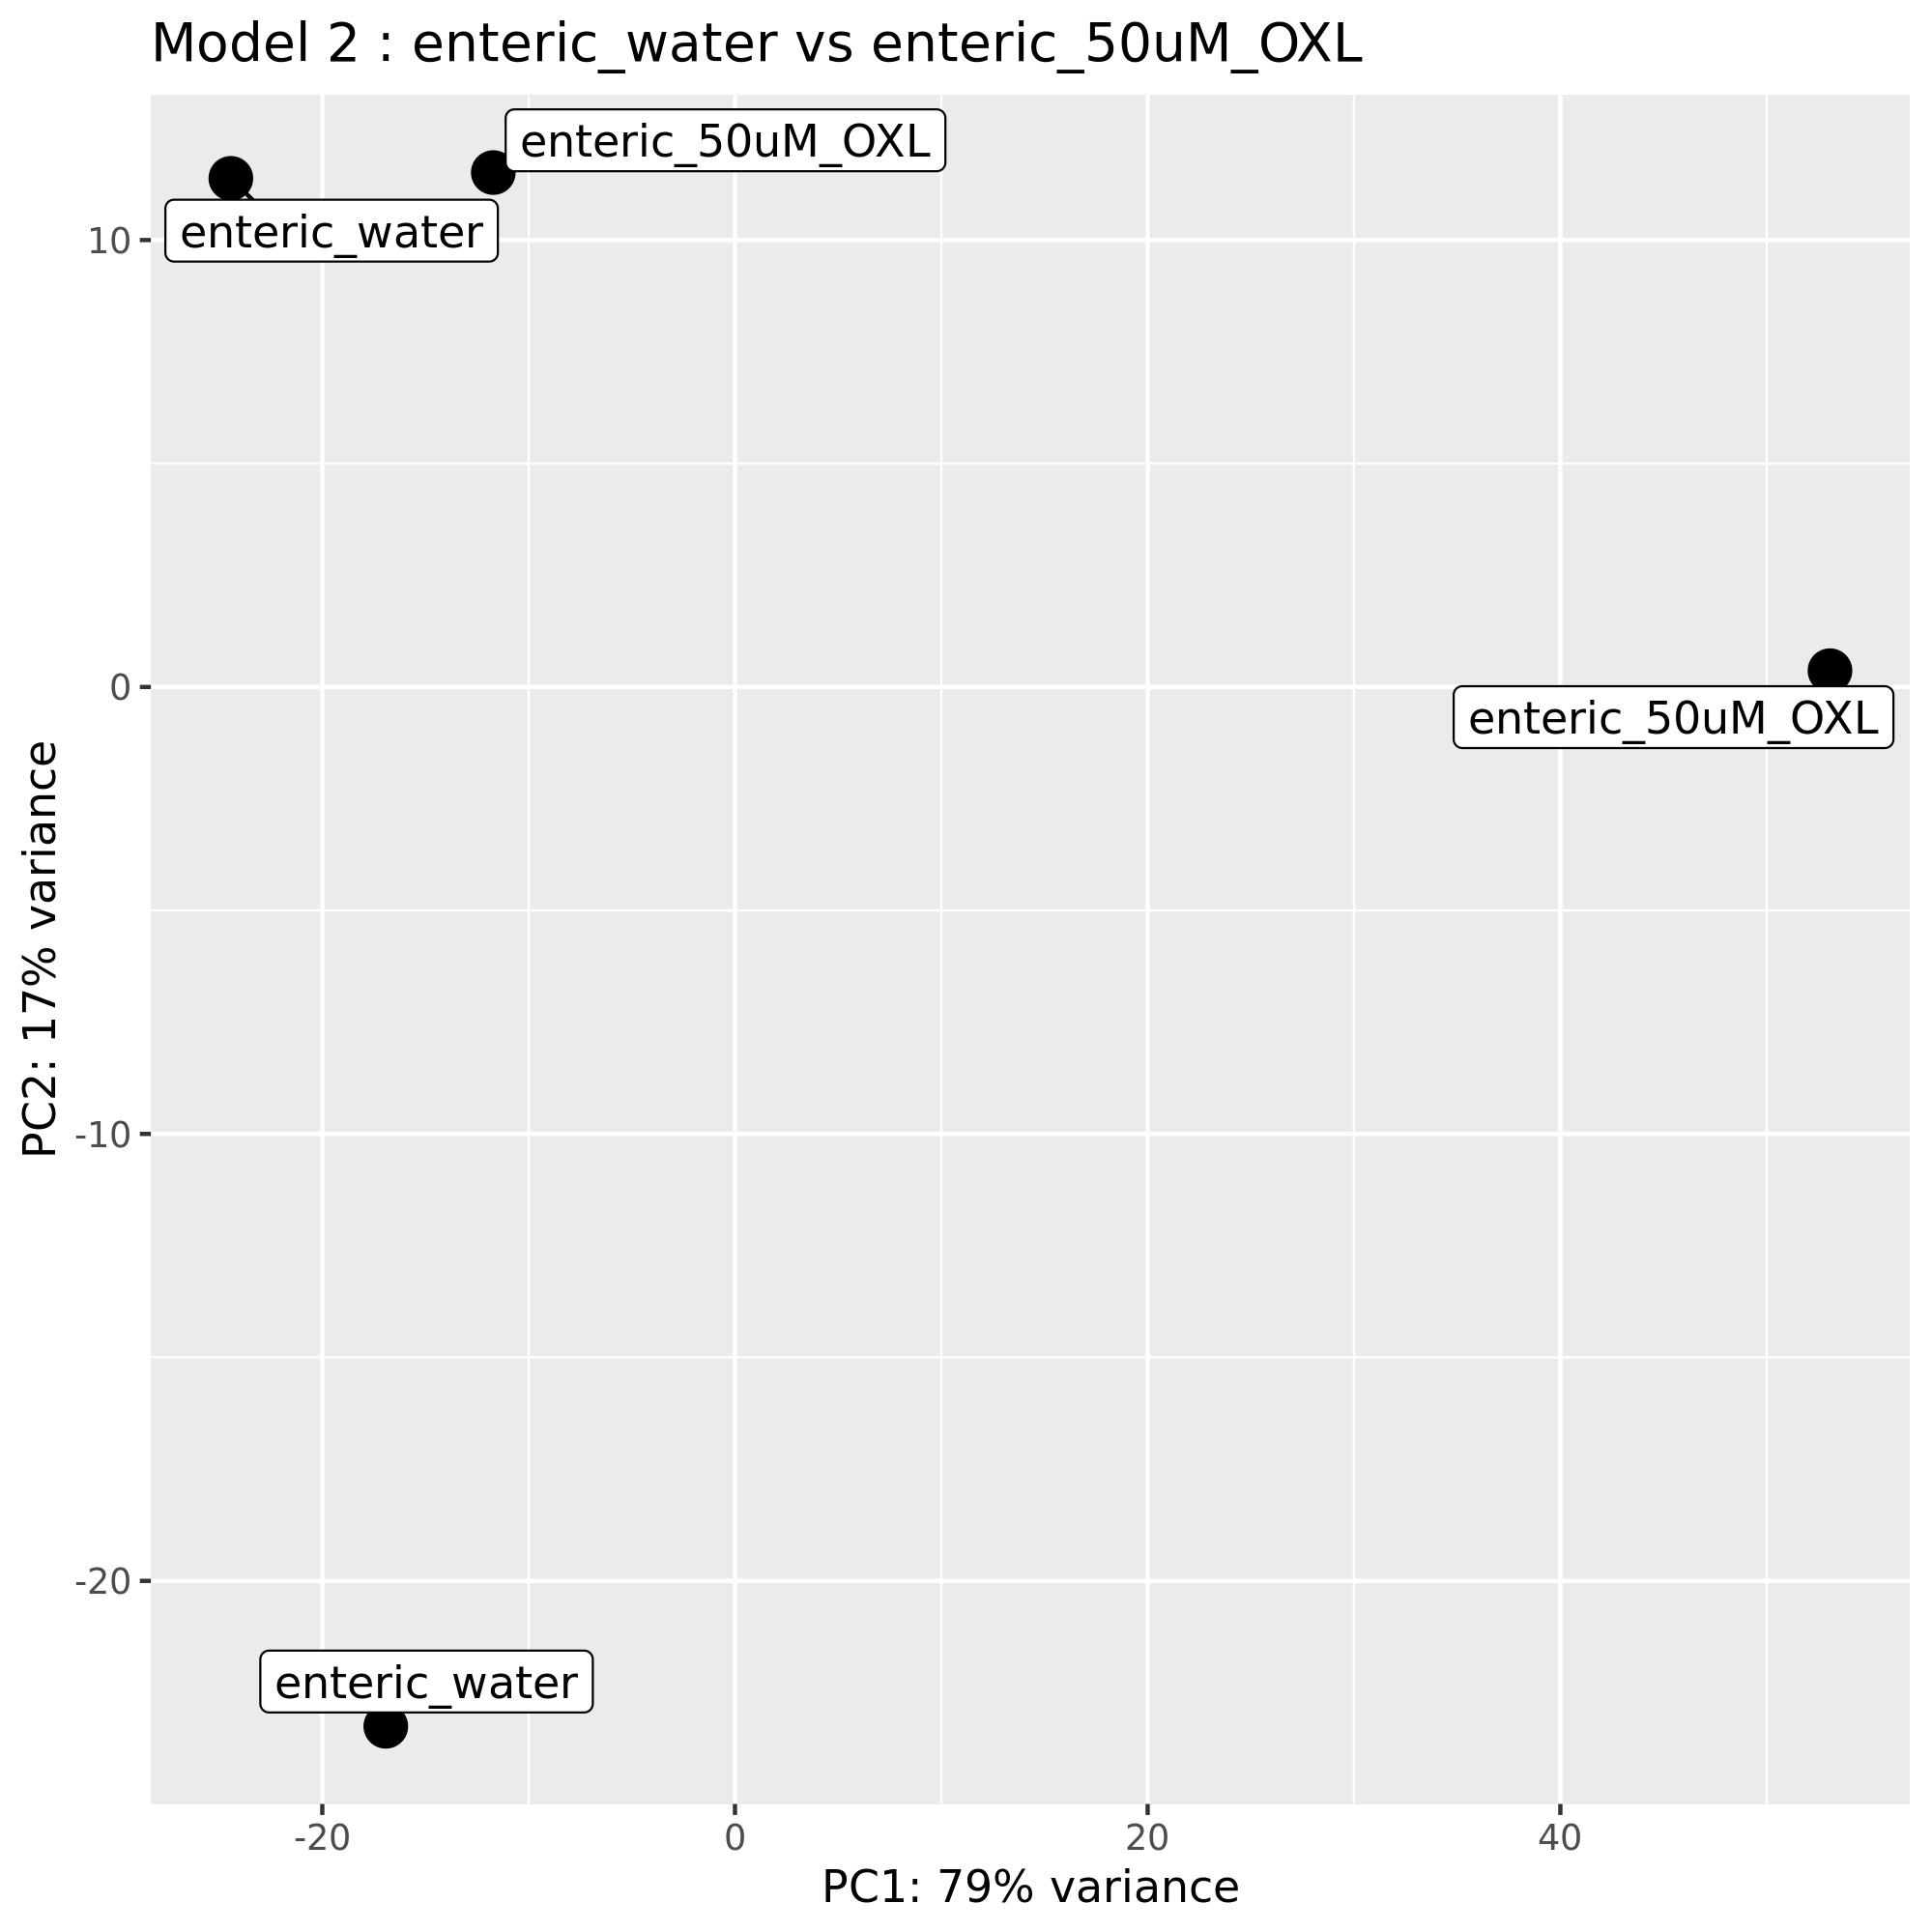

In [84]:
Image("model_2.png", width=500)

In [85]:
print (fs[1])
print(pandas.read_csv(fs[1], sep='\t')[['gene', 'pvalue','log2FoldChange']] )

model_2_enteric_water_vs_enteric_50uM_OXL_positive.txt
         gene        pvalue  log2FoldChange
0       ACTG2  8.422501e-04        3.036872
1       ACTN1  8.486682e-04        2.755253
2       ALPK2  2.288391e-04        4.926005
3      ANKRD1  5.777243e-08        6.473731
4       ANXA2  8.428425e-04        2.780357
5    APOBEC3C  2.673622e-05        5.422458
6        CAV1  1.624939e-07        5.694477
7      CITED2  4.066946e-04        4.325627
8        CPA4  8.749733e-05        3.826171
9        CTGF  3.942396e-05        4.956324
10      CYR61  4.155339e-07        5.442915
11        DSP  1.795896e-04        3.794702
12       EMP1  3.242283e-04        3.213863
13        FN1  7.883915e-04        2.833320
14     IGFBP3  3.721970e-05        3.737526
15      INHBA  6.903522e-04        2.607514
16   KIAA1755  6.809280e-04        7.797929
17      KLKP1  8.629886e-06        5.980297
18      KRT17  3.611656e-08        6.059939
19      KRT19  9.319909e-04        3.773836
20  LINC01164  8.5662

# 3

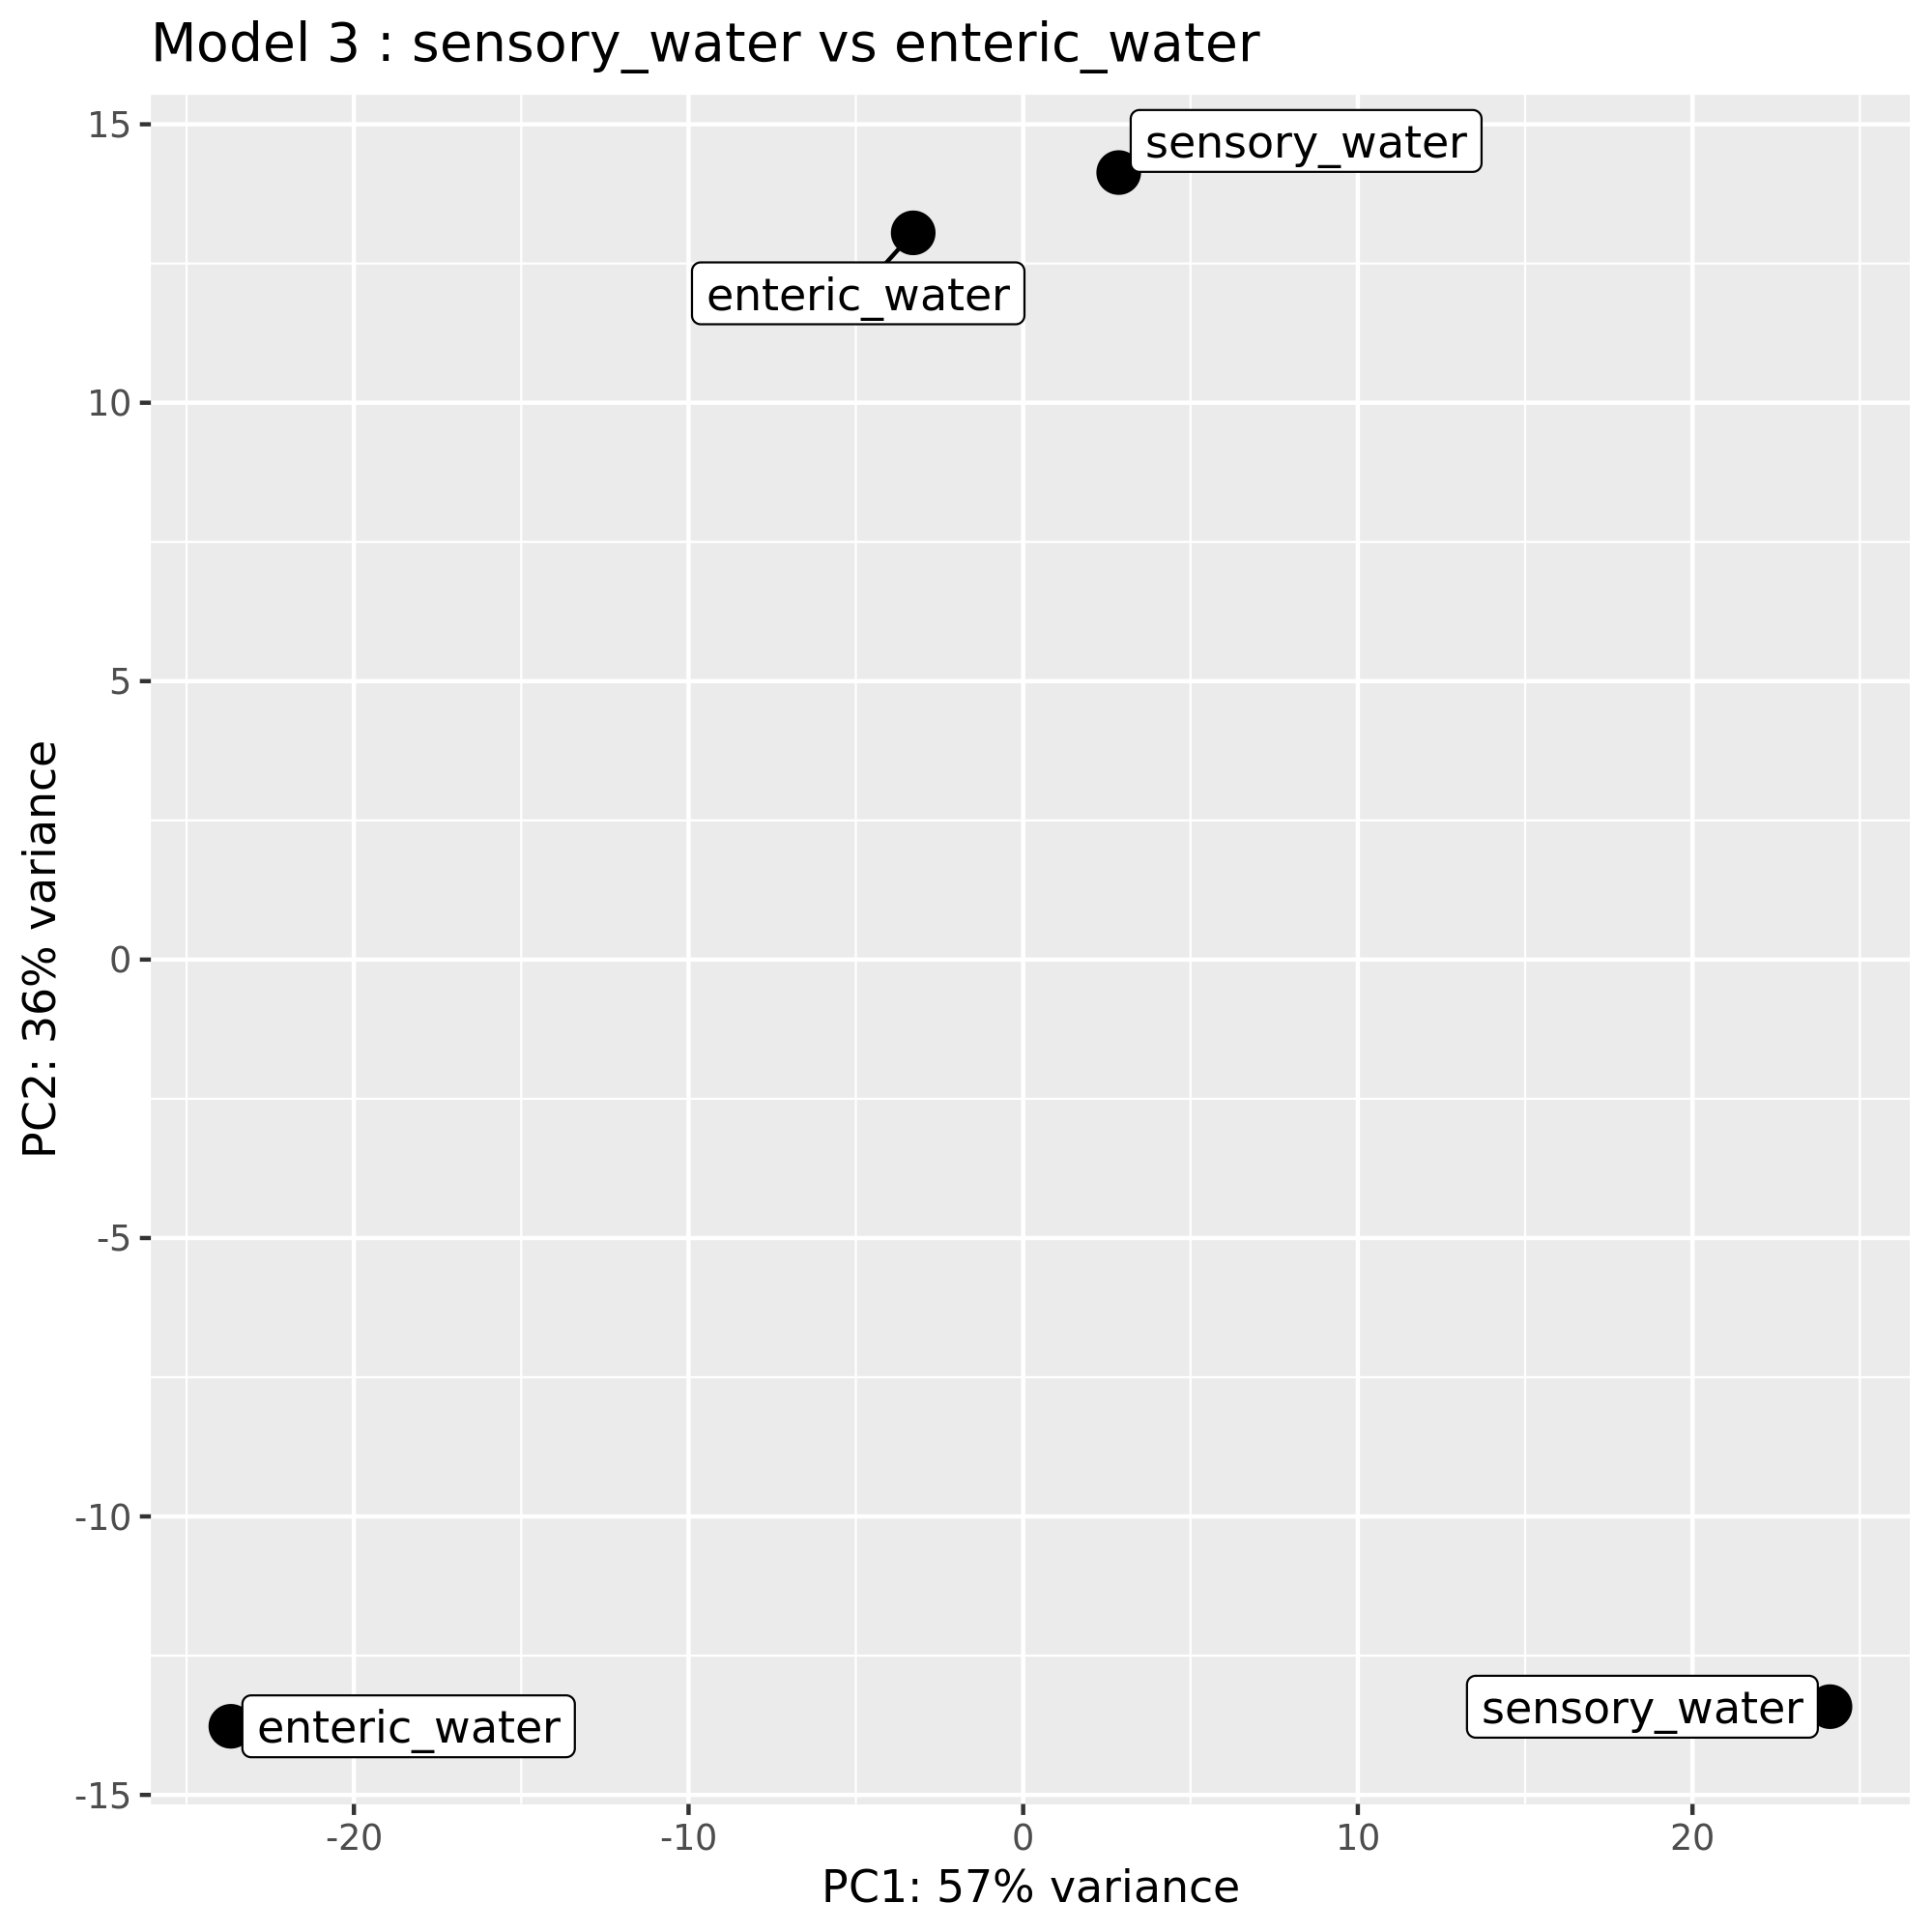

In [86]:
Image("model_3.png", width=500)

In [87]:
print (fs[2])
print(pandas.read_csv(fs[2], sep='\t')[['gene', 'pvalue','log2FoldChange']] )

model_3_sensory_water_vs_enteric_water_positive.txt
          gene        pvalue  log2FoldChange
0        ASCL1  2.504659e-06        7.281543
1       ATP1B1  3.401717e-04        2.084608
2      C1orf61  2.068079e-05        8.115127
3       CDKN1A  7.414859e-04        3.119212
4        CELF4  1.128918e-08        3.954050
5         DDR1  3.445020e-05        3.197140
6         DPF1  2.155977e-04        3.129570
7         DPF3  9.687011e-04        7.234878
8       ELAVL3  9.294163e-05        2.585940
9         GFAP  8.539481e-04        7.294177
10        GNG4  8.798641e-05        3.501264
11       GPM6A  8.859901e-07        3.932499
12       GRIA2  4.436161e-06        5.004497
13       GRIN1  6.889508e-04        7.393074
14       HAGLR  1.684059e-04        7.648598
15    HOTAIRM1  1.825430e-06        5.802710
16    HOXA-AS2  6.378684e-05        7.248854
17       HOXA4  4.367503e-05        7.370830
18       HOXB3  8.668538e-04        4.309663
19      HPCAL4  1.387267e-04        6.779020
20 

# 4

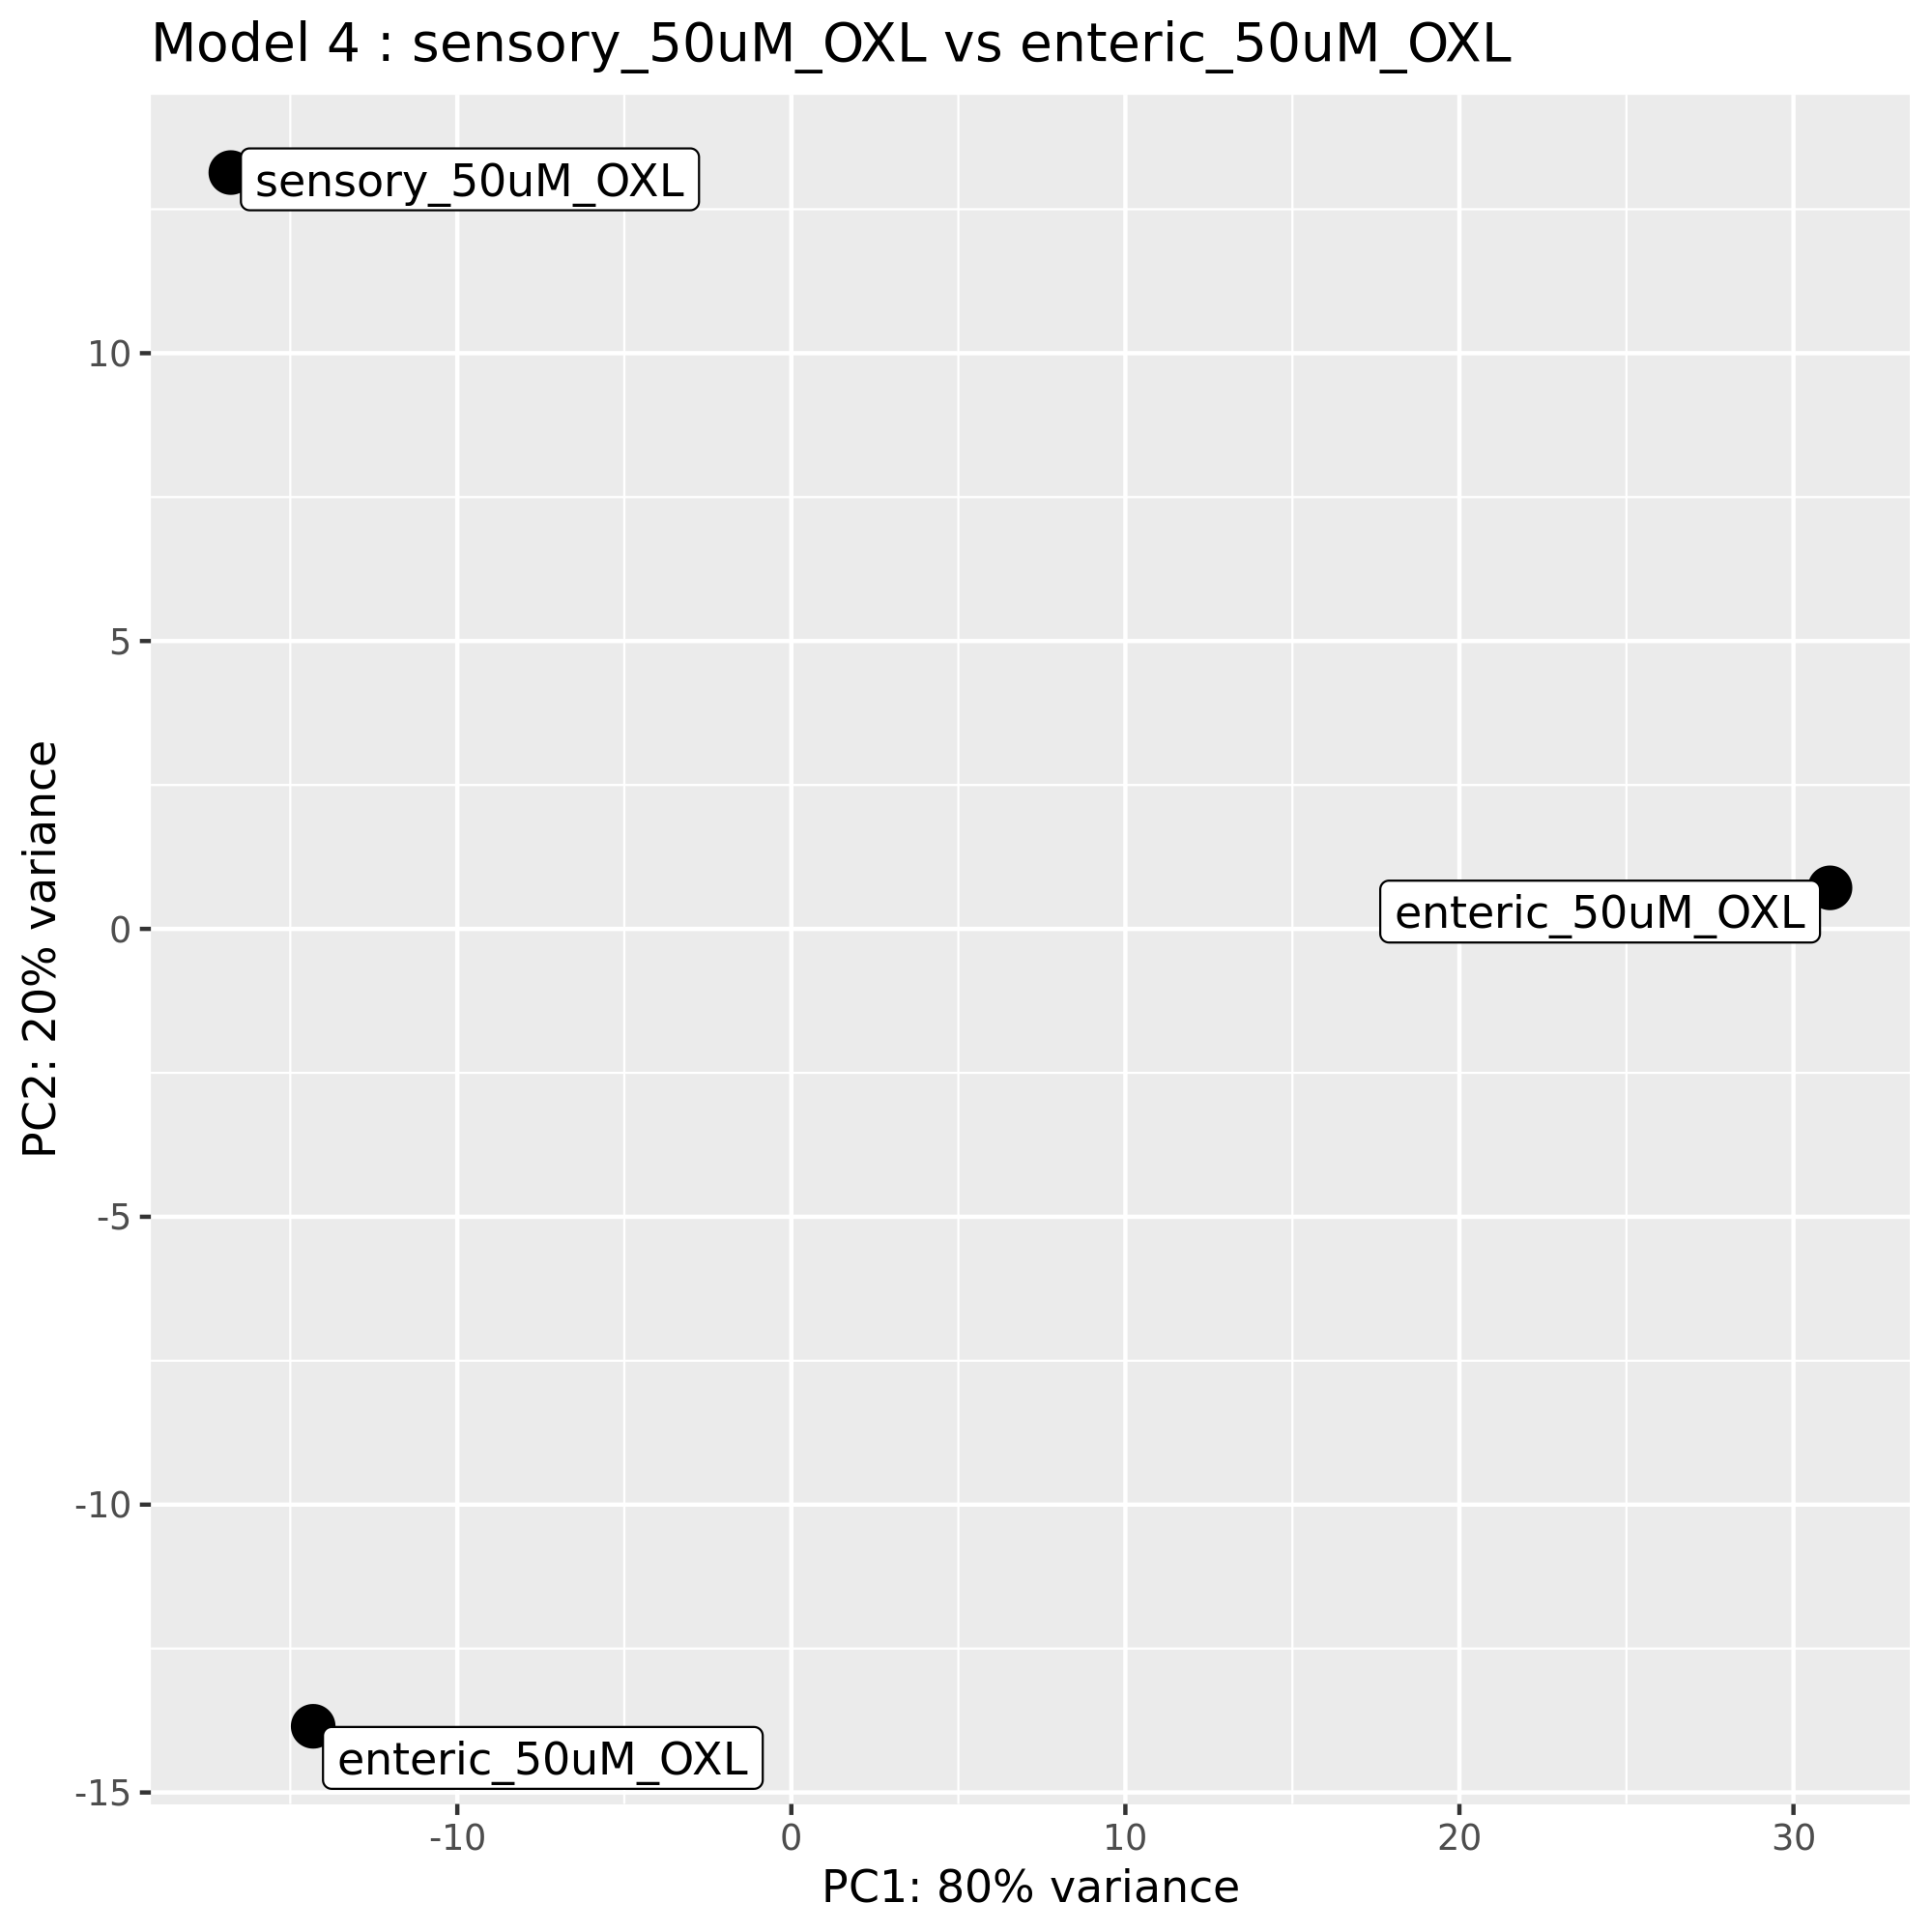

In [88]:
Image("model_4.png", width=500)

In [89]:
print (fs[3])
print(pandas.read_csv(fs[3], sep='\t')[['gene', 'pvalue','log2FoldChange']] )

model_4_sensory_50uM_OXL_vs_enteric_50uM_OXL_positive.txt
           gene    pvalue  log2FoldChange
0         ACTG2  0.000026        5.934771
1        ANKRD1  0.000010        6.279094
2          CPA4  0.000010        8.233102
3         CYR61  0.000064        5.142364
4        IGFBP3  0.000049        4.356835
5        IGFBP7  0.000720        4.181474
6         KRT19  0.000848        5.236106
7  LOC100289230  0.000858        8.689086
8          NPR3  0.000008       10.553592
9         SNHG3  0.000756        4.260628
